# Deconstructed Interactive Demo

This is a deconstructed version of the demo that is intended to show a bit more detail about the operation of `prospector`. It runs over the same example data as in the `demo_params.py` parameter file, using a similar model.  However, in this demo the implicit methods of the parameter file are made explicit.

First let's set up some environmental dependencies. These just make the numerics easier and adjust some of the plotting defaults to make things more legible.

In [1]:
import time, sys, os
import h5py
import numpy as np
from matplotlib.pyplot import *

%matplotlib inline

# re-defining plotting defaults
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

**Prospector** utilizes three main packages:
- **fsps**, which governs the fundamental stellar population synthesis models (via the **python-fsps** package),
- **sedpy**, which contains some routines for computing projecting spectra onto filter bandpasses, and
- **prospect**, which is where the likelihood evaluations, parameter priors, and posterior sampling takes place.

Let's import those now.

In [2]:
import fsps
import sedpy
import prospect

## Setup

We need several things to run a fit.  These include 
  1. An `obs` dictionary (with the data we intend to fit)
  2. A stellar population synthesis object (to predict spectra from parameters)
  3. A `model` object (to store and stranslate parameters and priors)
  4. A likelihood function
  
It can also useful to collect the meta-parameters contolling how the fit is done in a ``run_params`` dictionary.
We will do that as we go along.

### The data to be fit

The data to be fit is stored in a dictionary that we will call `obs`.
The `obs` dictionary stores the observed fluxes, uncertainties, and information about how those fluxes were measured.
For spectra this means the wavelengths at which the fluxes were measured, while for photometry we must know the filters through which the fluxes were measured.
This information is passed (via the `obs` dictionary) to the model object to specify which data to predict.

The units of the fluxes and uncertainties are assumed to be maggies (i.e Jy/3631).
The wavelength units are assumed to be observed frame vacuum angstroms.

We will create an `obs` dictionary below, with all of the required keys, starting with photometry.
In this example we use a row from Table 2 of Johnson et al. 2013

In [3]:
obs = {}
# Get the sedpy.observate.Filter objects that correspond to the measured fluxes and can be used
# First we are going to put together some filter names
galex = ['galex_FUV', 'galex_NUV']
spitzer = ['spitzer_irac_ch'+n for n in ['1','2','3','4']]
sdss = ['sdss_{0}0'.format(b) for b in ['u','g','r','i','z']]
filternames = galex + sdss + spitzer
# Now we instantiate the `Filter()` objects using methods in `sedpy`, 
# and put the resulting list of Filter object in the "filters" key of the obs dictionary
obs["filters"] = sedpy.observate.load_filters(filternames)
print(obs["filters"])

[<class 'sedpy.observate.Filter'>(galex_FUV), <class 'sedpy.observate.Filter'>(galex_NUV), <class 'sedpy.observate.Filter'>(sdss_u0), <class 'sedpy.observate.Filter'>(sdss_g0), <class 'sedpy.observate.Filter'>(sdss_r0), <class 'sedpy.observate.Filter'>(sdss_i0), <class 'sedpy.observate.Filter'>(sdss_z0), <class 'sedpy.observate.Filter'>(spitzer_irac_ch1), <class 'sedpy.observate.Filter'>(spitzer_irac_ch2), <class 'sedpy.observate.Filter'>(spitzer_irac_ch3), <class 'sedpy.observate.Filter'>(spitzer_irac_ch4)]


In [4]:
# Now we store the measured fluxes for a single object, **in the same order as "filters"**
# In this example we use a row of AB magnitudes from Johnson et al. 2013
# The units of the fluxes need to be maggies
dm = 30.0  # for 10Mpc distance
M_AB = np.array([-11.93, -12.37, -13.37, -14.22, -14.61, -14.86, -14.94, -14.09, -13.62, -13.23, -12.78])
mags = M_AB + dm
obs["maggies"] = 10**(-0.4*mags)
# We are going to assume here that the uncertainties are 10%
# in practice you should use real uncertainty estimates if you have them.
snr = 10.0
obs["maggies_unc"] = (1./snr) * obs["maggies"]
# Now we use a boolean mask to choose which filters to actually fit
# In this example we mask the spitzer filters.  This means that they aren't included in the fit,
# but predictions for the spitzer bands are still made
obs["phot_mask"] = np.array(['spitzer' not in f.name for f in obs["filters"]])
# we will also create a handy vector of effective wavelengths, though this is not required
obs["phot_wave"] = [f.wave_effective for f in obs["filters"]]

#Now let's see what the obs dictionary looks like
print(obs)

{'phot_wave': [1528.0585558648577, 2271.1247961282988, 3545.9817872504386, 4669.5792298981196, 6155.6709131865464, 7471.5456560638195, 8917.3343063996072, 35378.510121992826, 44780.550994056764, 56962.196576404291, 77980.204671931118], 'phot_mask': array([ True,  True,  True,  True,  True,  True,  True, False, False,
       False, False], dtype=bool), 'maggies': array([  5.91561634e-08,   8.87156012e-08,   2.22843515e-07,
         4.87528490e-07,   6.98232404e-07,   8.79022517e-07,
         9.46237161e-07,   4.32513831e-07,   2.80543364e-07,
         1.95884467e-07,   1.29419584e-07]), 'filters': [<class 'sedpy.observate.Filter'>(galex_FUV), <class 'sedpy.observate.Filter'>(galex_NUV), <class 'sedpy.observate.Filter'>(sdss_u0), <class 'sedpy.observate.Filter'>(sdss_g0), <class 'sedpy.observate.Filter'>(sdss_r0), <class 'sedpy.observate.Filter'>(sdss_i0), <class 'sedpy.observate.Filter'>(sdss_z0), <class 'sedpy.observate.Filter'>(spitzer_irac_ch1), <class 'sedpy.observate.Filter'>(spitz

Now we need to add keys describing the spectra.  In this example we don't have a spectrum, so we just need to do the following:

In [5]:
obs["wavelength"] = None  # this would be a vector of wavelengths in angstroms if we had 
obs["spectrum"] = None
obs['unc'] = None  #spectral uncertainties are given here
obs['mask'] = None

Finally, just to make sure everything is in the right format, we will run it through a little method that makes sure all the required keys are there (adding default values if necessary) and that can make some standard transformations of the data if requested (usually not advisable)

In [6]:
from prospect.utils.obsutils import fix_obs
obs = fix_obs(obs)

You can see the help for `fix_obs()` to look at the available options for this method.

It can be helpful to encapsulate all the logic for reading from your catalog into a single `load_obs` method.  Let's do that now.

In [7]:
def load_obs(snr=10, dm=30.0):
    galex = ['galex_FUV', 'galex_NUV']
    spitzer = ['spitzer_irac_ch'+n for n in ['1','2','3','4']]
    sdss = ['sdss_{0}0'.format(b) for b in ['u','g','r','i','z']]
    filternames = galex + sdss + spitzer
    
    # Here you could, e.g. read from a catalog
    M_AB = np.array([-11.93, -12.37, -13.37, -14.22, -14.61, -14.86, -14.94, -14.09, -13.62, -13.23, -12.78])
    mags = M_AB + dm

    obs = {}
    obs["filters"] = sedpy.observate.load_filters(filternames)
    obs["maggies"] = 10**(-0.4*mags)
    obs["maggies_unc"] = (1./snr) * obs["photometry"]
    obs["phot_mask"] = np.array(['spitzer' not in f.name for f in obs["filters"]])
    obs["phot_wave"] = [f.wave_effective for f in obs["filters"]]
    obs["wavelength"] = None  # this would be a vector of wavelengths in angstroms if we had 
    obs["spectrum"] = None
    obs['unc'] = None  #spectral uncertainties are given here
    obs['mask'] = None

    return obs

And we will store some meta-parameters that control the input arguments to this method:

In [8]:
run_params = {}
run_params["snr"] = 10.0
run_params["dm"] = 30.0

### The `sps` object
We need an object that will build SEDs for a given set of parameters.  In `prospector` we call these **sps** objects.  Given a dictionary of parameters, they must be able to return a spectrum, photometry, and maybe some ancillary information.  This is often done using large spectral libraries and, for galaxies, isochrone information.  Typically in `prospector` we use `fsps.StellarPopulation` objects, under thin wrappers that add a little functionality and change the API a bit. The different wrappers correspond to different SFH parameterizations. Here we use `CSPSpecBasis` which works with (linear combinations of) composite stellar populations as described in the FSPS manual with `sfh_type` of 1, 4, or 5:

In [9]:
from prospect.sources import CSPSpecBasis
# zcontinuous = 1 insures that we use interpolation between SSPs to 
# have a continuous metallicity parameter `logzsol` 
# See python-FSPS documentation for details
sps = CSPSpecBasis(zcontinuous=1)

This object often has a large memory footprint, since it contains all the spectral libraries and isochrones.
It has one very important method, `get_spectrum()`.  Indeed, the only definition of an `sps` object (for example if you want to make your own) is that it have this method.  In typical use, any FSPS parameter can be passed to this method as an extra keyword argument and the model will be built using that parameter.  Several additional parameters controlling, e.g., spectral smoothing or the wavelength calibration can also be passed to the default objects.

In [10]:
help(sps.get_spectrum)

Help on method get_spectrum in module prospect.sources.ssp_basis:

get_spectrum(self, outwave=None, filters=None, peraa=False, **params) method of prospect.sources.galaxy_basis.CSPSpecBasis instance
    Get a spectrum and SED for the given params.
    
    :param outwave: (default: None)
        Desired *vacuum* wavelengths.  Defaults to the values in
        `sps.wavelength`.
    
    :param peraa: (default: False)
        If `True`, return the spectrum in erg/s/cm^2/AA instead of AB
        maggies.
    
    :param filters: (default: None)
        A list of filter objects for which you'd like photometry to be calculated. 
    
    :param **params:
        Optional keywords giving parameter values that will be used to
        generate the predicted spectrum.
    
    :returns spec:
        Observed frame spectrum in AB maggies, unless `peraa=True` in which
        case the units are erg/s/cm^2/AA.
    
    :returns phot:
        Observed frame photometry in AB maggies.
    
    :retur

Again, it can be helpful to encapsulate the loading of the sps object in a `load_sps` method, with meta-parameters controlling the how the object is instantiated

In [11]:
def load_sps(zcontinuous=1):
    from prospect.sources import CSPSpecBasis
    sps = CSPSpecBasis(zcontinuous=zcontinuous)
    return sps

run_params["zcontinuous"] = 1

### The Model object

Now we need a set of model parameters, which will **define** the model we are tying to fit to the data.  The model object stores the parameters that are used by the SPS object to build a spectrum, as well as infomation about which parameters are to be varied during fitting, and priors on those parameters.  It efficiently converts between a vector of parameter values (the `theta` attribute) used by the MCMC samplers or optimizers and the dictionary of parameter names and values (the `params` attribute) that can be passed to the sps objects' `get_spectrum()` method.

To create the model object we need a list of model parameters and some infomation about them.  Each parameter must a have a name, a length (vector parameters are possible), an initial value, and must be specified as either a free parameter or a fixed parameter.  If it is a free parameter it needs a prior as well, which we will get from the `priors` module. Let's start by creating a dictionary that describes a single parameter controlling the stellar mass.

In [12]:
from prospect.models import priors
mass_param = {"name": "mass",
              "N": 1,  # The mass parameter here is a scalar
              "isfree": True,
              "init": 1e8,
              "disp_floor": 1e6, # this sets the minimum dispersion to use when generating clouds of emcee "walkers"
              "prior": priors.LogUniform(mini=1e6, maxi=1e12), # This sets the prior
              "units": "solar masses formed",  # This is not required, but can be helpful
              }

Ok, that's the description for one parameter.  Let's **build up the rest of our model** as a list of these parameter descriptions.  At a minimum we will need some sort of distance or redshift information (which in this example is a fixed parameter), and something descibing the SFH.  We could also add parameters controlling metallicity, dust attenuation and emission, nebular emission, even the IMF.

In [13]:
dist_param = {"name": "lumdist",
              "N": 1,
              "isfree": False,  # we do not fit for distance and mass simultaneously as they are degenerate
              "init": 10,
              "units": "Mpc",
              }

red_param = {"name": "zred",
             "N": 1,
             "isfree": False,
             "init": 0.0,
             "units": "redshift, see the python-FSPS documentation",
             }

met_param = {"name": "logzsol",
             "N": 1,
             "isfree": True,
             "init": -0.3,
             "prior": priors.TopHat(mini=-2.0, maxi=0.19),
             "units": "see the python-FSPS documentation"}

sfh_param = {"name": "sfh",
             "N": 1,
             "isfree": False,
             "init": 4,  # This corresponds to a delayed-tau SFH
             "units": "see the python-FSPS documentation"}

age_param = {"name": "tage",
             "N": 1,
             "isfree": True,
             "init": 13.0,
             "prior": priors.TopHat(mini=0.001, maxi=13.7),
             "units": "Gyr, see the python-FSPS documentation"}

tau_param = {"name": "tau",
             "N": 1,
             "isfree": True,
             "init": 1.0,
             "prior": priors.LogUniform(mini=1e-1, maxi=1e2),
             "units": "Gyr^{-1}, see the python-FSPS documentation"}

dust_param = {"name": "dust2",
              "N": 1,
              "isfree": True,
              "init": 0.0,
              "prior": priors.TopHat(mini=0.0, maxi=2.0),
              "units": "Optical depth at 5500AA, see the python-FSPS documentation"}

# Now lets put them all together
model_params = [mass_param, red_param, dist_param, met_param, 
                sfh_param, age_param, tau_param, dust_param]


Now we have a list of model parameter specifications that can be used to instantiate our model object.  Note that any parameter whose value is not explicitly specified via a model parameter dictionary will be given the default value from python-FSPS.

Let's instantiate the model object and then look at some of the parameter values.

In [14]:
from prospect.models import SedModel
model = SedModel(model_params)
print("Fixed parameters: {}".format(model.fixed_params))
print("Free parameters: {}".format(model.free_params))
print("Initial free parameter vector theta: {}".format(model.theta))
print("Initial parameter dictionary:{}".format(model.params))


Fixed parameters: ['zred', 'lumdist', 'sfh']
Free parameters: ['mass', 'logzsol', 'tage', 'tau', 'dust2']
Initial free parameter vector theta: [  1.00000000e+08  -3.00000000e-01   1.30000000e+01   1.00000000e+00
   0.00000000e+00]
Initial parameter dictionary:{'logzsol': array([-0.3]), 'dust2': array([ 0.]), 'tau': array([ 1.]), 'lumdist': array([10]), 'tage': array([ 13.]), 'zred': array([ 0.]), 'mass': array([  1.00000000e+08]), 'sfh': array([4])}


Great.  We now have a model.  We're fitting for 5 parameters here:
- stellar mass $M_\star$,
- metallicity $\log Z/Z_\odot$, 
- age $t$ of the galaxy 
- star formation timescale $\tau$ for an exponentially declining star formation history (SFH), and
- dust attenuation of old stellar populations $A_V$.

Everything else here is fixed explicitly.  There are many other `sps` parameters that are set implicitly in the FSPS defaults.

Let's change some of the parameter values in a couple different ways, and look at the prior probablity for those new parameter combinations.

In [15]:
theta = model.theta.copy()
print("Initial parameters:{}".format(model.theta))
print("Initial ln_prior_probability:{}".format(model.prior_product(theta)))

# let's increase the mass by a factor of 10 by manipulating the copied theta vector
theta[model.theta_index["mass"]] *= 10
print("New ln_prior_probability:{}".format(model.prior_product(theta)))
#note that the new parameter vector does not get propogated into the model object by the prior_product() call
print(model.theta)
print(model.params["mass"])
# but we can force that to happen by doing this
model.set_parameters(theta)
print(model.theta)
print(model.params["mass"])

# Now let's increase the mass again by accessing the params dictionary directly 
#(instead of through a separate theta vector)
# This is the only way to change fixed parameters
model.params["mass"] *= 10
print(model.params["mass"])
print(model.theta) # the change now shows up in the model.theta attribute
print(theta)  # but the external theta vector did not change
# So let's use the model.theta attribute to calculate again the prior probability
print("New ln_prior_probability:{}".format(model.prior_product(model.theta)))

Initial parameters:[  1.00000000e+08  -3.00000000e-01   1.30000000e+01   1.00000000e+00
   0.00000000e+00]
Initial ln_prior_probability:-27.0734889542
New ln_prior_probability:-29.3760740472
[  1.00000000e+08  -3.00000000e-01   1.30000000e+01   1.00000000e+00
   0.00000000e+00]
[  1.00000000e+08]
[  1.00000000e+09  -3.00000000e-01   1.30000000e+01   1.00000000e+00
   0.00000000e+00]
[  1.00000000e+09]
[  1.00000000e+10]
[  1.00000000e+10  -3.00000000e-01   1.30000000e+01   1.00000000e+00
   0.00000000e+00]
[  1.00000000e+10  -3.00000000e-01   1.30000000e+01   1.00000000e+00
   0.00000000e+00]
New ln_prior_probability:-31.6786591402


Now we can also generate a prediction for the data from any set of model parameters.  To see how this works, lets make an SED!

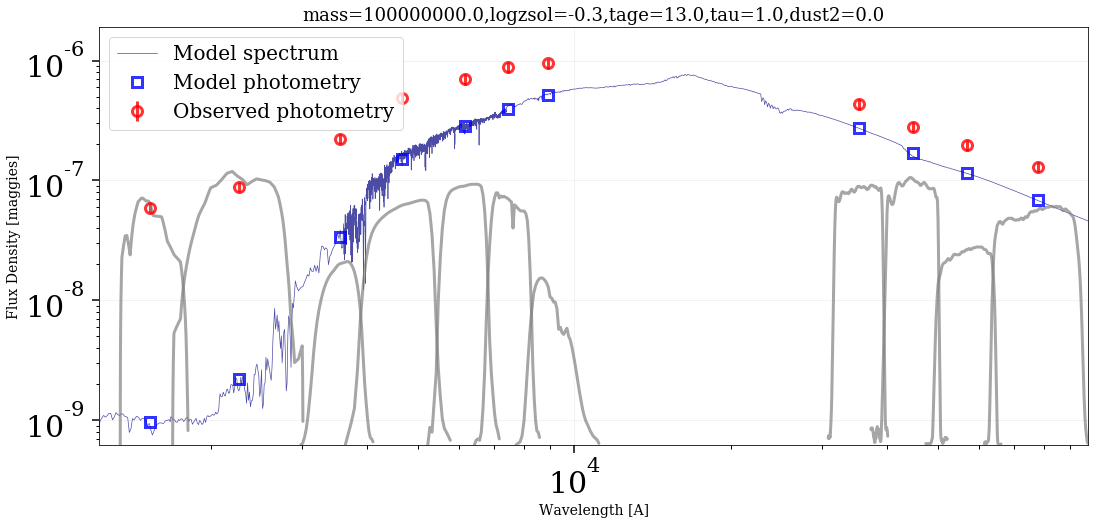

In [16]:
# Generate the model SED at some value of theta
theta = model.theta.copy()
theta[model.theta_index["mass"]] = 1e8
initial_spec, initial_phot, initial_mfrac = model.sed(theta, obs=obs, sps=sps)
title_text = ','.join(["{}={}".format(p, model.params[p][0]) for p in model.free_params])
#spec, phot, x = sps.get_spectrum(outwave=obs['wavelength'], filters=obs["filters"], **model.params)

a = 1.0 + model.params.get('zred', 0.0) # cosmological redshifting
# photometric effective wavelengths
wphot = obs["phot_wave"]
# spectroscopic wavelengths
if obs["wavelength"] is None:
    # *restframe* spectral wavelengths, since obs["wavelength"] is None
    wspec = sps.wavelengths
    wspec *= a #redshift them
else:
    wspec = obs["wavelength"]

# establish bounds
xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
temp = np.interp(np.linspace(xmin,xmax,10000), wspec, initial_spec)
ymin, ymax = temp.min()*0.8, temp.max()/0.4
figure(figsize=(16,8))

# plot model + data
loglog(wspec, initial_spec, label='Model spectrum', 
       lw=0.7, color='navy', alpha=0.7)
errorbar(wphot, initial_phot, label='Model photometry', 
         marker='s',markersize=10, alpha=0.8, ls='', lw=3,
         markerfacecolor='none', markeredgecolor='blue', 
         markeredgewidth=3)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry',
         marker='o', markersize=10, alpha=0.8, ls='', lw=3,
         ecolor='red', markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)
title(title_text)

# plot Filters
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    while t.max() > 1:
        t /= 10.
    t = 0.1*(ymax-ymin)*t + ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

# prettify
xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()


Note that creating a new model with FSPS is somewhat time-intensive (of order seconds), but once the relevant SSPs have been built they are subsequently stored in cache so similar models can be generated much more quickly (unless you are changing parameters that affect the SSPs, like the IMF)

As for the ``obs`` dictionary and the ``sps`` object it can be sueful to define a ``load_model`` method that instantiates the ``model`` object.  This method can also be used to change the parameter specification dictionaries according to adjustable arguments.  Let's do an example where we change whether the metallicity is a free and fitted parameter or fixed to a particular value, and where we can set the redshift by hand as well.

In [17]:
def load_model(object_redshift=None, fixed_metallicity=None):
    
    from prospect.models.sedmodel import SedModel

    # here we change the model parameter specifications based on some keyword arguments
    pnames = [m['name'] for m in model_params]
    if fixed_metallicity is not None:
        zind = pnames.index('logzsol')
        model_params[zind]['isfree'] = False # make it a fixed parameter
        model_params[zind]['init'] = fixed_metallicity #use value supplied by fixed_metallicity
        
    if object_redshift is not None:
        zind = pnames.index('zred')
        model_params[zind]['init'] = object #use value supplied by object_redshift
        
    model = SedModel(model_params)
    return model

run_params["object_redshift"] = 0.0
run_params["fixed_metallicity"] = None # could change to a specific value of logzsol to fix the metallicity to that value

### Likelihood function
Now all we are missing is a likelihood function.  In most cases, this will simply be a function of the **spectral likelihood** and a **photometric likelihood** such that

$$
\mathcal{L} = f(\mathcal{L}_{\textrm{spec}}, \mathcal{L}_{\textrm{phot}}) \quad .
$$

Assuming our errors are Normal (i.e. Gaussian), the log-likelihoods for each component are extremely straightforward to define and can be imported directly from Prospector.  How we choose to combine these likelihoods might vary depending on the particulars of our data. For the demo, our likelihood function for our model parameters $\boldsymbol{\theta}$ is just

$$
\ln\mathcal{L}(\boldsymbol{\theta}) = \ln\mathcal{L}_{\textrm{spec}}(\boldsymbol{\theta}) + \ln\mathcal{L}_{\textrm{phot}}(\boldsymbol{\theta}) \quad .
$$

Below is a simple version of the likelihood function used in `prospector`.  Note that more complicated likelihoods including covariant noise and fitted noise parameters are possible, using special NoiseModel classes within `prospector`.  Also we are using the globally defined `obs`, `model`, and `sps`; in principle these could be passed as arguments to the `lnprobfn`.

For nested sampling `lnprobfn(theta, nested=True)` will return the likelihood (since the prior probability is accounted for by drawing proposals from the priors), while for other types of MCMC sampling `lnprobfn(theta, nested=False)` returns the posterior probability.

In [18]:
from prospect.likelihood import lnlike_spec, lnlike_phot, write_log

verbose = False
def lnprobfn(theta, nested=False, verbose=verbose):
    """
    Given a parameter vector, a dictionary of observational data 
    a model object, and an sps object, return the ln of the posterior. 
    This requires that an sps object (and if using spectra 
    and gaussian processes, a GP object) be instantiated.
    """

    # Calculate prior probability and exit if not within prior
    # Also if doing nested sampling, do not include the basic priors, 
    # since the drawing method includes the prior probability
    lnp_prior = model.prior_product(theta, nested=nested)
    if not np.isfinite(lnp_prior):
        return -np.infty
        
    # Generate "mean" model
    t1 = time.time()
    spec, phot, x = model.mean_model(theta, obs, sps=sps)
    d1 = time.time() - t1
 
    # Calculate likelihoods
    t2 = time.time()
    lnp_spec = lnlike_spec(spec, obs=obs)
    lnp_phot = lnlike_phot(phot, obs=obs)
    d2 = time.time() - t2
    if verbose:
        write_log(theta, lnp_prior, lnp_spec, lnp_phot, d1, d2)

    return lnp_prior + lnp_phot + lnp_spec

run_params["verbose"] = verbose

## Running Prospector

### Outputs

We are just about ready to do the inference. But before we start running anything, let's just check whether we can write out our fits to an HDF5 file. If not, we'll just dump them at the end.  As the HDF5 output is set up, the `model_params` list, the `obs` dictionary, and the `run_params` dictionary are serialized (if possible) and added as attributes or datasets in the HDF5 file.

In [19]:
from prospect.io import write_results

In [20]:
run_params["outfile"] = 'demo'
outroot = "{0}_{1}".format(run_params['outfile'], int(time.time()))
try:
    hfilename = outroot + '_mcmc.h5'
    hfile = h5py.File(hfilename, "a")
    print("Writing to file {}".format(hfilename))
    write_results.write_h5_header(hfile, run_params, model)
    write_results.write_obs_to_h5(hfile, obs)
except:
    hfile = None

Writing to file demo_1513183904_mcmc.h5
Could not serialize model_params


### Minimization Step
We can attempt to initialize our model reasonably close to the data by using some numerical minimization routines.
Here we will use Levenberg-Marquardt. Keywords that control the optimization algorithm will again be stored in the `run_params` dictionary. Levenberg-Marquardt requires a likelihood function that returns a vector of chi values, not an actual likelihood, so we will write that. It's important to note that in the function below we do *not* account for prior probabilities.

In [21]:
from prospect import fitting
from scipy.optimize import least_squares
run_params["nmin"] = 5
run_params['ftol'] = 3e-16 
run_params['maxfev'] = 5000
run_params['xtol'] = 3e-16

In [22]:
from prospect.likelihood import chi_spec, chi_phot
def chivecfn(theta):
    """A version of lnprobfn that returns the simple uncertainty 
    normalized residual instead of the log-posterior, for use with 
    least-squares optimization methods like Levenburg-Marquardt.
    
    It's important to note that the returned chi vector does not 
    include the prior probability.
    """
    lnp_prior = model.prior_product(theta)
    if not np.isfinite(lnp_prior):
        return -np.infty

    # Generate mean model
    t1 = time.time()
    try:
        spec, phot, x = model.mean_model(theta, obs, sps=sps)
    except(ValueError):
        return -np.infty
    d1 = time.time() - t1

    chispec = chi_spec(spec, obs)
    chiphot = chi_phot(phot, obs)
    return np.concatenate([chispec, chiphot])

# --- start minimization ----
min_method = 'levenberg_marquardt'
run_params["min_method"] = min_method

# We'll start minimization from "nmin" separate places, 
# the first based on the "init" values of each parameter and the 
# rest drawn from the prior.  This can guard against local minima.
nmin = run_params["nmin"]
ts = time.time()  # time it
pinitial = fitting.minimizer_ball(model.initial_theta.copy(), nmin, model)
guesses = []
for i, pinit in enumerate(pinitial): #loop over initial guesses
    res = least_squares(chivecfn, pinit, method='lm', x_scale='jac',
                        xtol=run_params["xtol"], ftol=run_params["ftol"], 
                        max_nfev=run_params["maxfev"])
    guesses.append(res)

# Calculate chi-square of the results, and choose the best one
# fitting.reinitialize moves the parameter vector away from edges of the prior.
chisq = [np.sum(r.fun**2) for r in guesses]
best = np.argmin(chisq)
initial_center = fitting.reinitialize(guesses[best].x, model,
                        edge_trunc=run_params.get('edge_trunc', 0.1))
initial_prob = None
pdur = time.time() - ts

# output results
print('done {0} in {1}s'.format(min_method, pdur))
print('best {0} guess: {1}'.format(min_method, initial_center))
print('best {0} chi-sq: {1}'.format(min_method, chisq[best]))

done levenberg_marquardt in 26.7113339901s
best levenberg_marquardt guess: [  1.32817133e+08  -2.00000000e+00   1.02789559e+01   3.39362639e+00
   6.43542400e-01]
best levenberg_marquardt chi-sq: 1.64999312457


/usr/local/lib/python2.7/site-packages/prospect-5c509de-py2.7.egg/prospect/models/priors.py:142: RuntimeWarning: divide by zero encountered in log


Now let's see how our model looks.

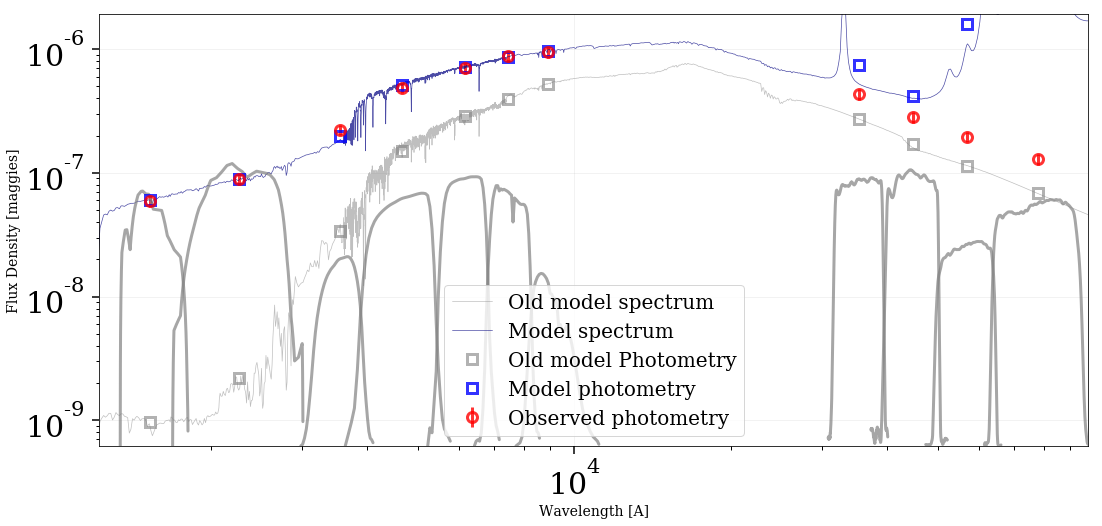

In [23]:
# initial parameters
theta = initial_center
# generate model
prediction = model.mean_model(theta, obs, sps=sps)
mspec, mphot, mextra = prediction

figure(figsize=(16,8))

# plot Data, models, and old models
loglog(wspec, initial_spec, label='Old model spectrum',
       lw=0.7, color='gray', alpha=0.5)
errorbar(wphot, initial_phot, label='Old model Photometry', 
         marker='s', markersize=10, alpha=0.6, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='gray', 
         markeredgewidth=3)
loglog(wspec, mspec, label='Model spectrum', 
       lw=0.7, color='navy', alpha=0.7)
errorbar(wphot, mphot, label='Model photometry', 
         marker='s', markersize=10, alpha=0.8, ls='', lw=3,
         markerfacecolor='none', markeredgecolor='blue', 
         markeredgewidth=3)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'],
         label='Observed photometry', 
         marker='o', markersize=10, alpha=0.8, ls='', lw=3, 
         ecolor='red', markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)

# plot filter transmission curves
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    while t.max() > 1:
        t /= 10.
    t = 0.1*(ymax-ymin)*t + ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

# Prettify
xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()

That should look much better, except maybe for the filters that we have masked out.

### Sampling the Posterior

Now that we're somewhat burned in, we can begin sampling from the posterior using **Markov Chain Monte Carlo** (MCMC). Prospector by default uses **emcee**, and will try to parallelize the process over multiple cores when available through MPI and mpi4py. In this interactive notebook though we will assume single-threaded operation. 

The `emcee` algorithm requires several options to be specified, related to the number of walkers, the number of iterations, and to rounds of burn-in.  For convenience we will store these in the `run_params` meta-parameter dictionary that we've been using.

In [24]:
# Number of emcee walkers
run_params["nwalkers"] = 128
# Number of iterations of the MCMC sampling
run_params["niter"] = 512
# Number of iterations in each round of burn-in
# After each round, the walkers are reinitialized based on the 
# locations of the highest probablity half of the walkers.
run_params["nburn"] = [16, 32, 64]
# The following number controls how often the chain is written to disk.
# Ths can be useful to make sure that not all is lost if the code dies during a long MCMC run
# It ranges from 0 to 1; the current chains will be written out every `interval` * `niter` iterations
# The default is 1, i.e. only write out at the end of the run
run_params["interval"] = 0.25 # write out after every 25% of the sampling is completed.

Let's go ahead and start sampling!

In [25]:
# suppress output
fout = sys.stdout
fnull = open(os.devnull, 'w')
sys.stdout = fnull

tstart = time.time()  # time it
out = fitting.run_emcee_sampler(lnprobfn, initial_center, model,
                                pool=None, hdf5=hfile, **run_params)
esampler, burn_loc0, burn_prob0 = out
edur = time.time() - tstart

sys.stdout = fout

print('done emcee in {0}s'.format(edur))

done emcee in 293.485409975s


Now that everything's all set, let's save our results to disk.  These will be written to 2 or 3 files beginning with the value of `outroot`.

In [26]:
write_results.write_hdf5(hfile, run_params, model, obs, esampler, 
                         guesses,
                         toptimize=pdur, tsample=edur,
                         sampling_initial_center=initial_center,
                         post_burnin_center=burn_loc0,
                         post_burnin_prob=burn_prob0)

# The code below can be used to write python pickles (like IDL save files) to disk.  
# These are not necessary, but can be convenient.
#write_results.write_pickles(run_params, model, obs, esampler, guesses,
#                            outroot=outroot, toptimize=pdur, tsample=edur,
#                            sampling_initial_center=initial_center,
#                            post_burnin_center=burn_loc0,
#                            post_burnin_prob=burn_prob0)

print('Finished')

Could not serialize model_params
Finished


## Visualizing the Results

There are a few basic plotting tools available to do a quick check on the results available in *prospect.io.read_results* and *prospect.utils.plotting*. We'll hack a few of these together in *plot_utils* here in the demo folder to make them a bit more amenable to plotting in this notebook.

In [35]:
import plot_utils as pread
from prospect.io.read_results import results_from, get_sps
print(outroot)

demo_1513183904


Reading our results from our Pickle or HDF5 file is straightforward.

In [36]:
# grab results, the obs dictionary, and our corresponding models
res, obs, mod = results_from("{}_mcmc.h5".format(outroot))

To see how our MCMC samples look, we can examine a few traces.

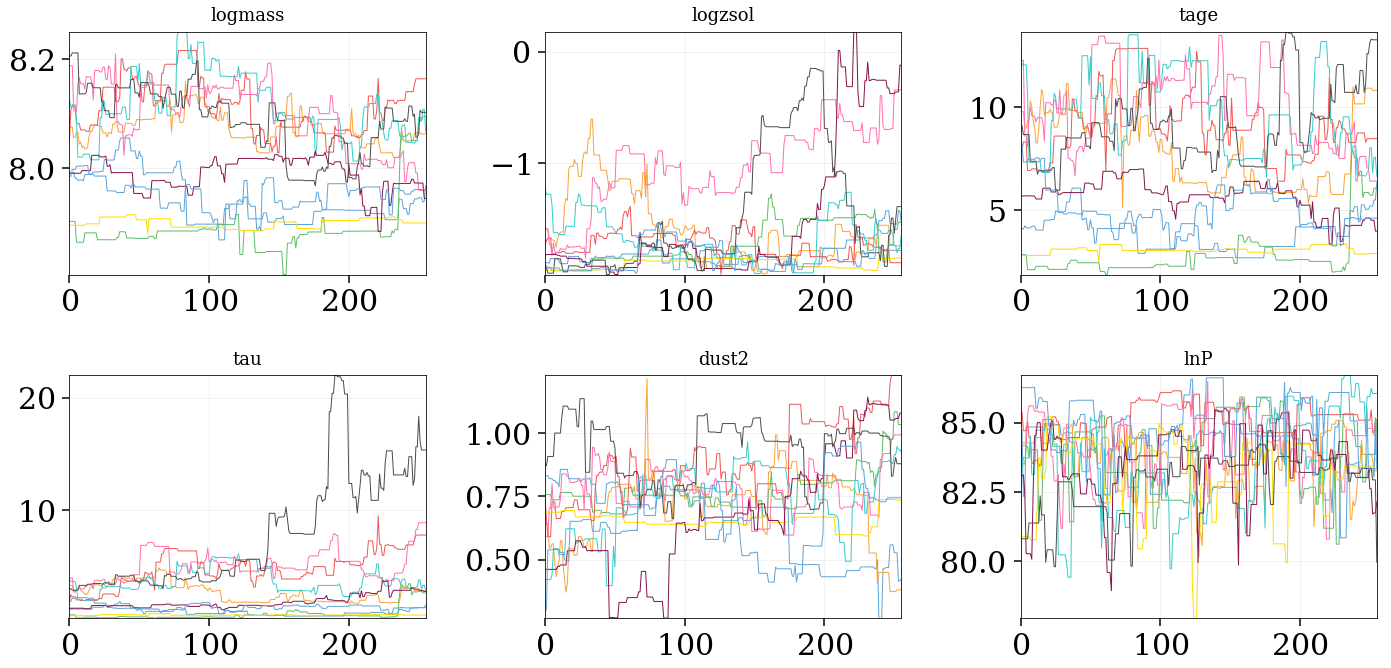

In [37]:
choice = np.random.choice
tracefig = pread.param_evol(res, figsize=(20,10), 
                            chains=choice(run_params["nwalkers"], size=10, replace=False))

Our samples more generally can be shown using a corner/triangle plot.  The `subtriangle()` method below is a very thin wrapper on Dan Foreman-Mackey's **corner.py** code.  We'll overplot the MAP value as blue lines.

Optimization value: [  1.32817133e+08  -2.00000000e+00   1.02789559e+01   3.39362639e+00
   6.43542400e-01]
MAP value: [  5.46870240e+07  -2.10906073e-01   1.46272361e+00   3.61408323e-01
   7.74378181e-01]


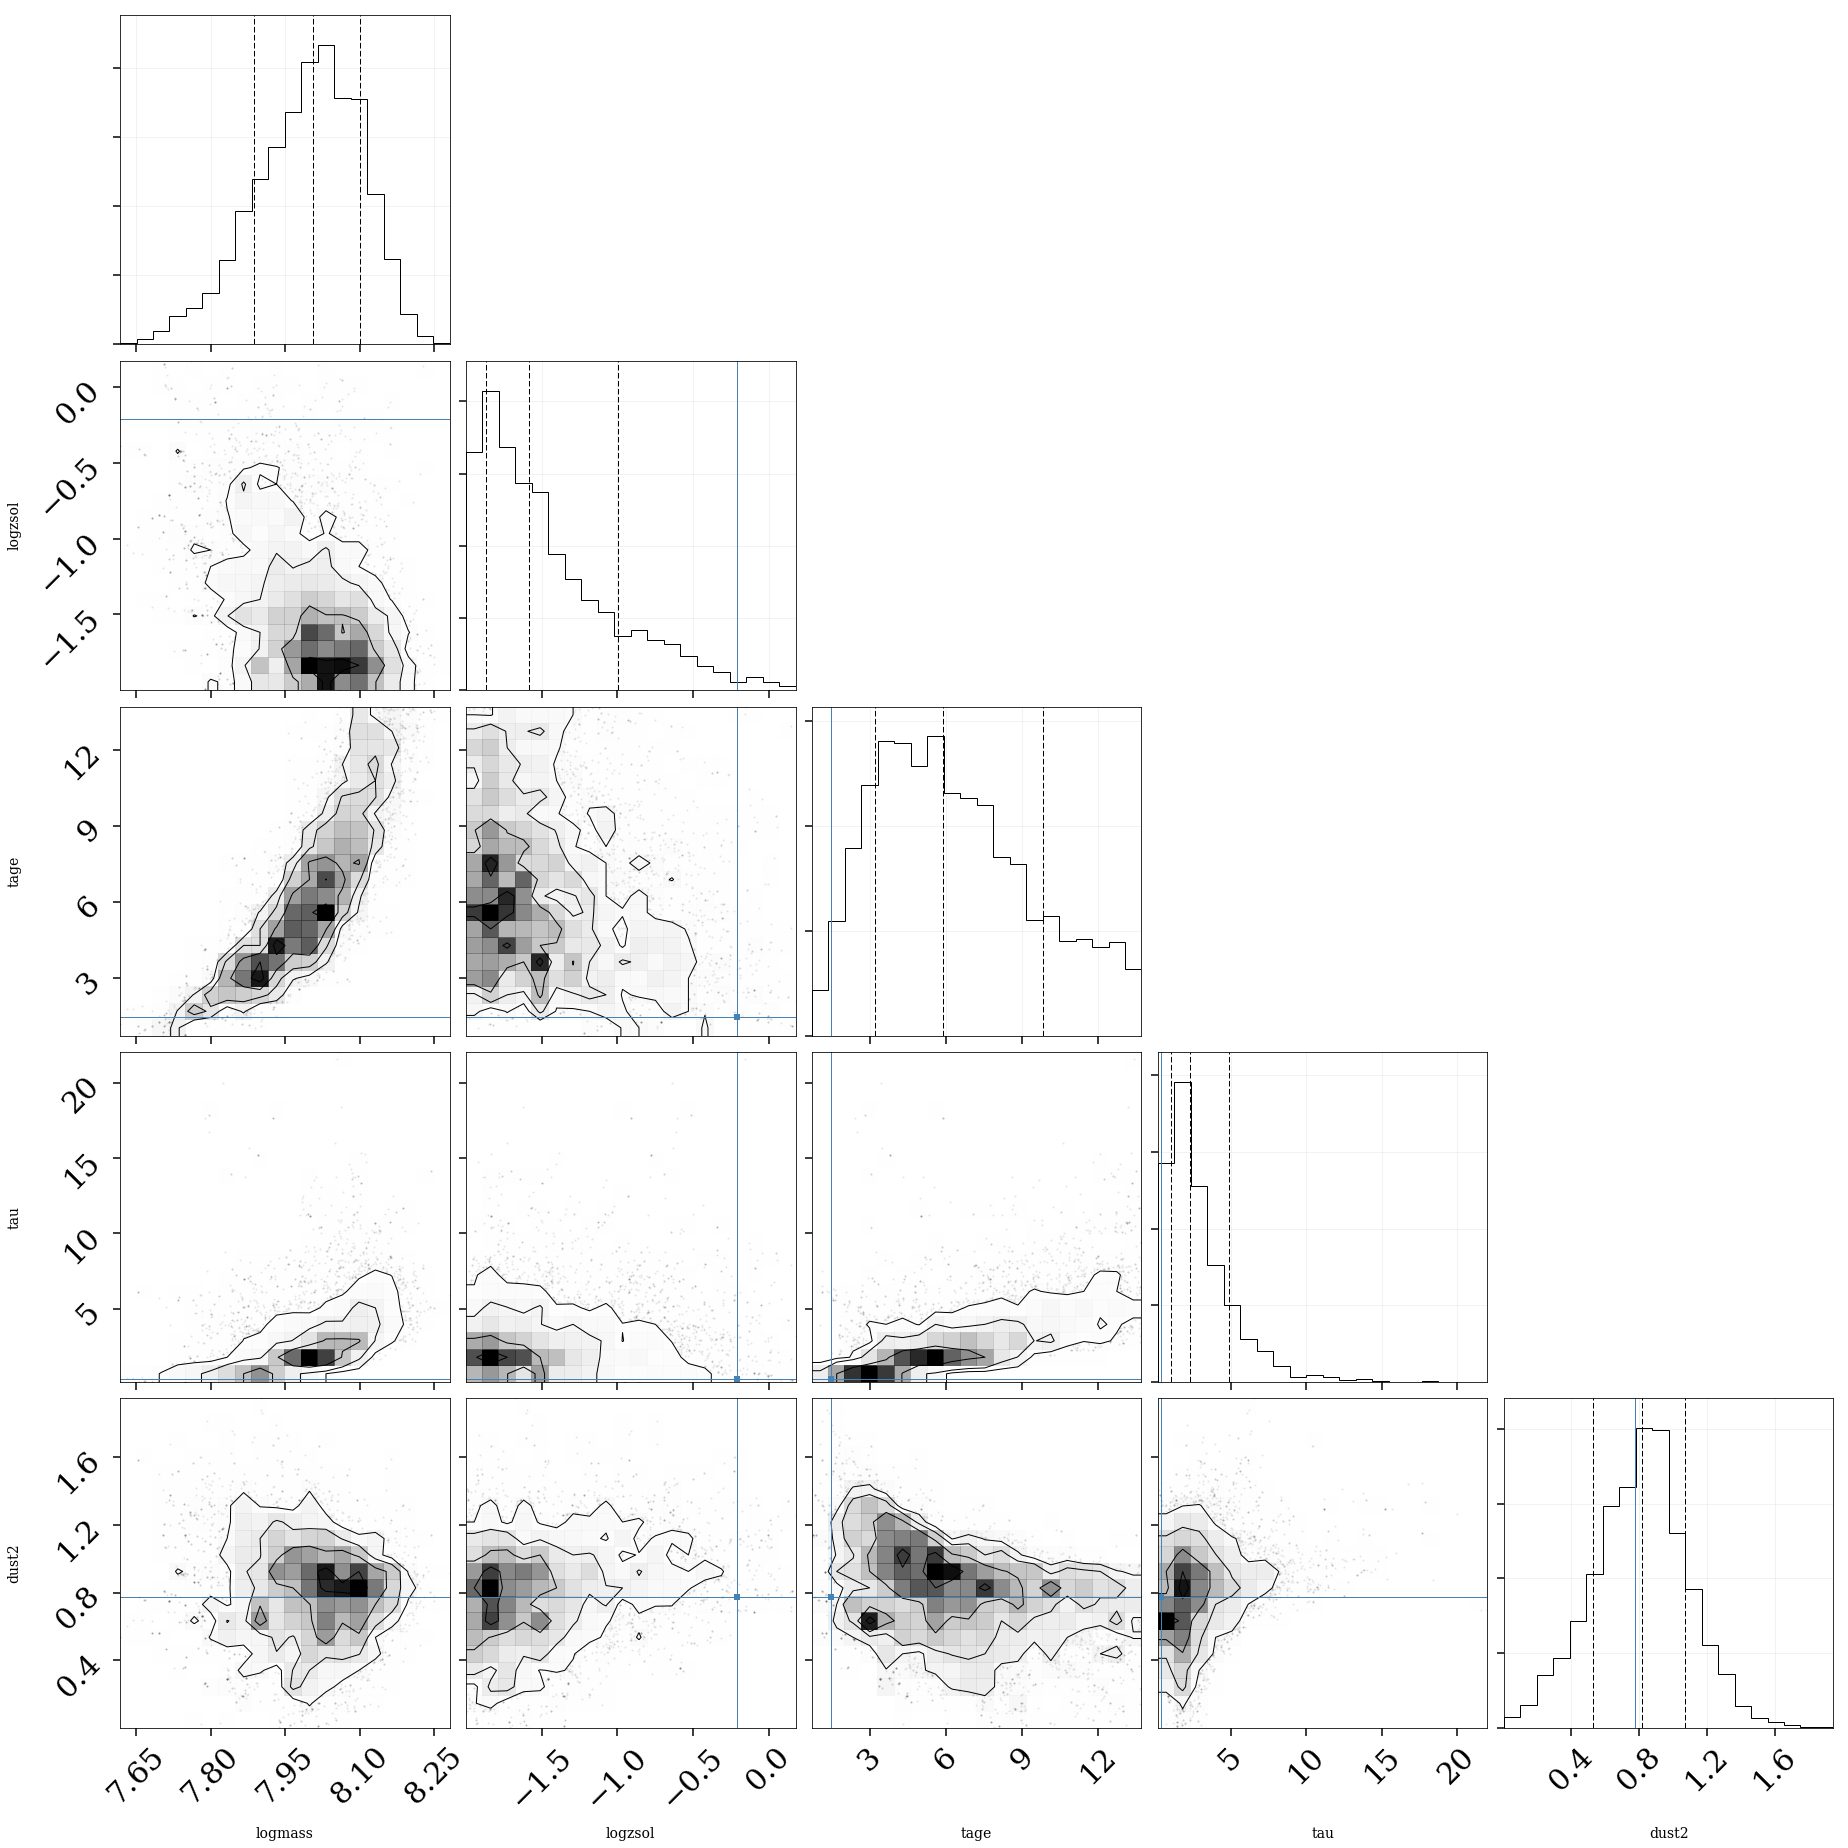

In [39]:
# maximum a posteriori (of the locations visited by the MCMC sampler)
imax = np.argmax(res['lnprobability'])
i, j = np.unravel_index(imax, res['lnprobability'].shape)
theta_map = res['chain'][i, j, :].copy()

print('Optimization value: {}'.format(initial_center))
print('MAP value: {}'.format(theta_map))

cornerfig = pread.subtriangle(res, start=0, thin=5, truths=theta_map, 
                              fig=subplots(5,5,figsize=(27,27))[0])

Finally, let's just take a look at a random model drawn from our chain, and at the highest posterior probability model in the chain.  In this notebook we already have the `sps` object instantiated, but in general we may have to regenerate it using the `load_obs` method above

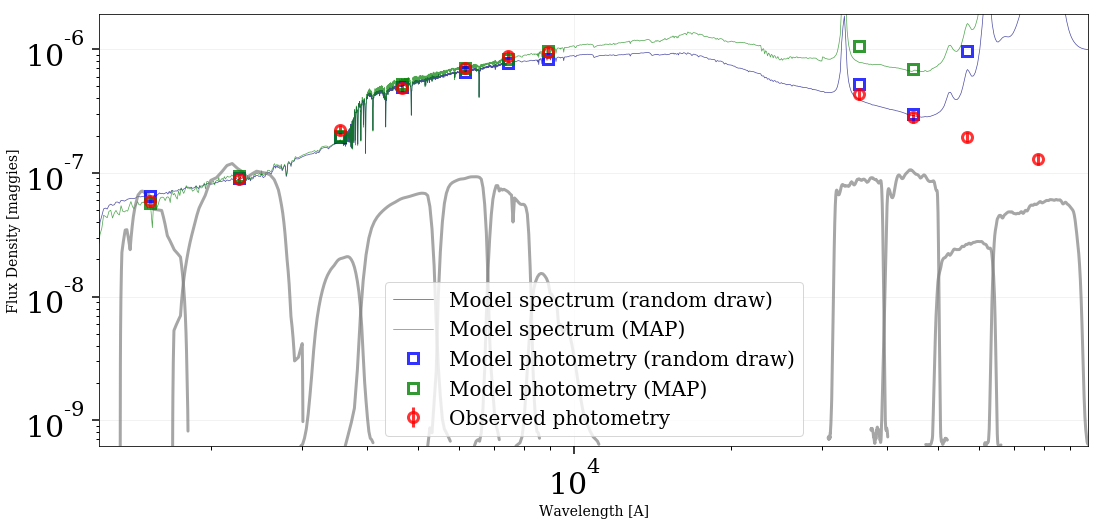

In [41]:
# randomly chosen parameters from chain
randint = np.random.randint
nwalkers, niter = run_params['nwalkers'], run_params['niter']
theta = res['chain'][randint(nwalkers), randint(niter)]

# generate models
# sps = get_sps(res)  # this works if using parameter files
mspec, mphot, mextra = model.mean_model(theta, obs, sps=sps)
mspec_map, mphot_map, _ = model.mean_model(theta_map, obs, sps=sps)

# Make plot of data and model
figure(figsize=(16,8))

loglog(wspec, mspec, label='Model spectrum (random draw)',
       lw=0.7, color='navy', alpha=0.7)
loglog(wspec, mspec_map, label='Model spectrum (MAP)',
       lw=0.7, color='green', alpha=0.7)
errorbar(wphot, mphot, label='Model photometry (random draw)',
         marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='blue', 
         markeredgewidth=3)
errorbar(wphot, mphot_map, label='Model photometry (MAP)',
         marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='green', 
         markeredgewidth=3)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry', ecolor='red', 
         marker='o', markersize=10, ls='', lw=3, alpha=0.8, 
         markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)

# plot transmission curves
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    while t.max() > 1:
        t /= 10.
    t = 0.1*(ymax-ymin)*t + ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()